# Data 시작 onset부터 자르기

In [1]:
SR = 44100

# Data Sequence하게 자르기

In [2]:
import essentia
from essentia.standard import MonoLoader, OnsetDetection, Windowing, FFT, CartesianToPolar, FrameGenerator, Onsets, AudioOnsetsMarker, StereoMuxer, AudioWriter
from tempfile import TemporaryDirectory

# first onset detection function
def onset_detect(input_path):
  # Load audio file.
  audio = MonoLoader(filename=input_path)()

  # 1. Compute the onset detection function (ODF).

  # The OnsetDetection algorithm provides various ODFs.
  od_hfc = OnsetDetection(method='hfc')
  od_complex = OnsetDetection(method='complex')

  # We need the auxilary algorithms to compute magnitude and phase.
  w = Windowing(type='hann')
  fft = FFT() # Outputs a complex FFT vector.
  c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

  # Compute both ODF frame by frame. Store results to a Pool.
  pool = essentia.Pool()
  for frame in FrameGenerator(audio, frameSize=1024, hopSize=512):
      magnitude, phase = c2p(fft(w(frame)))
      pool.add('odf.hfc', od_hfc(magnitude, phase))
      pool.add('odf.complex', od_complex(magnitude, phase))

  # 2. Detect onset locations.
  onsets = Onsets()

  onsets_hfc = onsets(# This algorithm expects a matrix, not a vector.
                      essentia.array([pool['odf.hfc']]),
                      # You need to specify weights, but if we use only one ODF
                      # it doesn't actually matter which weight to give it
                      [1])

  onsets_complex = onsets(essentia.array([pool['odf.complex']]), [1])

  # first onset 이 2초 이상인 것을 우선시
  if onsets_hfc[0] >= 2:
    return onsets_hfc[0]
  return onsets_complex[0]

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [3]:
# trimmed audio
def audio_trim_per_onset(audio, first_onset, sr=SR):
  start = (int)(first_onset * sr)
  trimmed = audio[start:]
  return trimmed

In [4]:
import scipy.io.wavfile

# trimmed audio -> wav file write
def write_trimmed_audio(root_path, name, trimmed_audio):
  # exist or not
  if not os.path.exists(root_path):
    # if the demo_folder directory is not present
    # then create it.
    os.makedirs(root_path)
  scipy.io.wavfile.write(f'{root_path}/{name}.wav', SR, trimmed_audio)

In [5]:
import os
import librosa

# load audio & trimmed per onset
# [pattern, per_drum]
# per_drum: [1_HH, 2_RC, ...], pattern: [P1, P2, ...]
# 04, 08, 16
def main(root_path, trim_path):
  datas = os.listdir(root_path)

  check = False
  for d in datas:
    if d.endswith('.m4a'):
      check = True
      wav = os.path.join(root_path, d)
      print(wav)

      # detect onsets
      onsets = onset_detect(wav)
      # print(onsets)

      # trimming audio
      audio, sr = librosa.load(wav, sr=SR)
      trimmed_audios = audio_trim_per_onset(audio, onsets, sr)
      # print(trimmed_audios)

      # new_file write
      name = d[:-4]
      write_trimmed_audio(trim_path, name, trimmed_audios)
    elif d.endswith('.txt') == False:
      new_root_path = os.path.join(root_path, d)
      new_trim_path = os.path.join(trim_path, d)
      main(new_root_path, new_trim_path)

In [ ]:
# 드럼 녹음 data path
input_file_path = ""
root_path = "../data/raw_data/" + input_file_path
trim_path = "../data/sequence_data/" + input_file_path
main(root_path, trim_path)

# 데이터 라벨링

## onset detection

In [2]:
import essentia
from essentia.standard import MonoLoader, OnsetDetection, Windowing, FFT, CartesianToPolar, FrameGenerator, Onsets, AudioOnsetsMarker, StereoMuxer, AudioWriter
from tempfile import TemporaryDirectory

# onset detection function
def onset_detect(input_path):
  # Load audio file.
  audio = MonoLoader(filename=input_path)()

  # 1. Compute the onset detection function (ODF).

  # The OnsetDetection algorithm provides various ODFs.
  od_hfc = OnsetDetection(method='hfc')
  od_complex = OnsetDetection(method='complex')

  # We need the auxilary algorithms to compute magnitude and phase.
  w = Windowing(type='hann')
  fft = FFT() # Outputs a complex FFT vector.
  c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

  # Compute both ODF frame by frame. Store results to a Pool.
  pool = essentia.Pool()
  for frame in FrameGenerator(audio, frameSize=1024, hopSize=512):
      magnitude, phase = c2p(fft(w(frame)))
      pool.add('odf.hfc', od_hfc(magnitude, phase))
      pool.add('odf.complex', od_complex(magnitude, phase))

  # 2. Detect onset locations.
  onsets = Onsets()

  onsets_hfc = onsets(# This algorithm expects a matrix, not a vector.
                      essentia.array([pool['odf.hfc']]),
                      # You need to specify weights, but if we use only one ODF
                      # it doesn't actually matter which weight to give it
                      [1])

  onsets_complex = onsets(essentia.array([pool['odf.complex']]), [1])

  # crush 08 박자 예외처리
  if "CC" in input_path and "08" in input_path:
    return onsets_hfc[:1]
  # crush 04 박자 예외처리
  if "CC" in input_path and "04" in input_path:
    return onsets_hfc[:4]

  # onset 개수가 짝수인 것을 우선
  if len(onsets_hfc) % 2 == 0:
    return onsets_hfc
  elif len(onsets_complex) % 2 == 0:
    return onsets_complex
  elif len(onsets_hfc) > len(onsets_complex):
    return onsets_hfc
  else:
    return onsets_complex

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


## 한 악기 씩 라벨링 따로

In [4]:
"""
CC : 0
HH : 1
KK : 7
SD : 5
"""

drum2code = {'CC':0, 'HH':1, 'KK':7, 'SD':5}
code2drum = {0:'CC', 1:'HH', 7:'KK', 5:'SD'}

DRUM = 0

In [ ]:
import os
import numpy as np
import random

data_root_path = f"../data/sequence_data/per_drum/{DRUM}_{code2drum[DRUM]}"
beat_folders = os.listdir(data_root_path)

X_data_full = []
for beat in beat_folders:
  X_data_full += [os.path.join(data_root_path, beat, file) for file in os.listdir(os.path.join(data_root_path, beat))]

random.shuffle(X_data_full)
X_data_full

### data labeling

In [31]:
ONSET_DURATION = 0.1
TIME_WIDTH = 1024
N_FFT = 2048
HOP_LENGTH = 512
WIN_LENGTH = 2048

In [32]:
import librosa

def data_labeling(datas):
  X_data = []
  Y_data = []

  # data load
  for path in datas:
    # load audio wav array
    audio, sr = librosa.load(path, sr=SR)
    print(path)

    # translate STFT
    stft = librosa.stft(y=audio, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, window='hann')
    stft = np.abs(stft, dtype=np.float64)
    if stft.shape[1] < TIME_WIDTH:
      stft_new = np.pad(stft, pad_width=((0,0), (0, TIME_WIDTH - stft.shape[1])), mode='constant')
    else:
      stft_new = stft[:, :TIME_WIDTH]
    stft_new = np.transpose(stft_new)
    X_data.append(stft_new)

    # onset detection & labeling
    # onset position : 1
    # onset position with ONSET_DURATION : 0.5
    # extra : 0
    onsets_arr = onset_detect(path)
    labels = [0.0] * TIME_WIDTH
    print(onsets_arr)
    for onset in onsets_arr:
      soft_start_position = max((onset - ONSET_DURATION), 0) * SR / HOP_LENGTH
      onset_position = onset * SR / HOP_LENGTH
      soft_end_position = (onset + ONSET_DURATION) * SR / HOP_LENGTH
      for i in range((int)(soft_start_position), (int)(soft_end_position)):
        if labels[i] == 1:
          continue
        labels[i] = 0.5
      labels[(int)(onset_position)] = 1

    Y_data.append(labels)

  return np.array(X_data), np.array(Y_data)

In [33]:
X_data, Y_data = data_labeling(X_data_full)

../data/sequence_data/per_drum/1_HH/08/HH_08_0002.wav
[0.01160998 0.29024944 0.6037188  0.90557826 1.2190477  1.520907
 1.8459864  2.1362357 ]
../data/sequence_data/per_drum/1_HH/08/HH_08_0019.wav
[0.01160998 0.31346938 0.62693876 0.9287982  1.2306576  1.532517
 1.8227664  2.124626  ]
../data/sequence_data/per_drum/1_HH/04/HH_04_0003.wav
[0.01160998 0.5688889  1.1493877  1.7066667 ]
../data/sequence_data/per_drum/1_HH/16/HH_16_0055.wav
[0.01160998 0.17414966 0.3018594  0.4643991  0.6037188  0.7662585
 0.90557826 1.0681179  1.1958277  1.3583673  1.4976871  1.6602267
 1.7879364  1.9388663  2.066576   2.2291157 ]
../data/sequence_data/per_drum/1_HH/16/HH_16_0038.wav
[0.01160998 0.19736962 0.3018594  0.45278913 0.6037188  0.7894785
 0.8939682  1.056508   1.1842177  1.3699774  1.4976871  1.6253968
 1.7879364  2.0897958  2.2407255 ]
../data/sequence_data/per_drum/1_HH/16/HH_16_0059.wav
[0.01160998 0.16253968 0.31346938 0.45278913 0.6037188  0.7546485
 0.8939682  1.0448979  1.1958277  1.34675

In [35]:
X_data.shape

(170, 1024, 1025)

In [36]:
# split train & test dataset
test_cnt = (int)(X_data.shape[0] * 0.2)

X_train, Y_train = X_data[:-test_cnt], Y_data[:-test_cnt]
X_test, Y_test = X_data[-test_cnt:], Y_data[-test_cnt:]

X_train.shape, Y_train.shape

((136, 1024, 1025), (136, 1024))

### trash

In [12]:
# Y_train reshape
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1], 1))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1], 1))

Y_train.shape, Y_test.shape

((81, 1024, 1), (20, 1024, 1))

### STFT 그래프

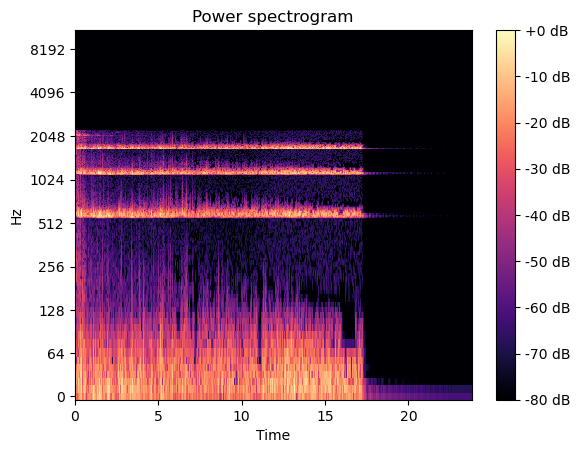

In [64]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(X_data[0],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

## 여러 악기 한 번에 라벨링

In [3]:
code2drum = {0:'CC', 1:'HH', 2:'RC', 3:'ST', 4:'MT', 5:'SD', 6:'FT', 7:'KK'}
# -- {'CC':0, 'HH':1, ...}
drum2code = {v: k for k, v in code2drum.items()}
# -- {0:'CC', 1:'HH', ...}

onehot_drum2code = {}
# -- {'CC':[1,0,0,0,0,0,0,0], 'HH':[0,1,0,0,0,0,0,0], ...}
for code, index in drum2code.items():
    drum_mapping = [0] * len(drum2code)
    drum_mapping[index] = 1
    onehot_drum2code[code] = drum_mapping

pattern = {'HH':onehot_drum2code['HH'],
           'SD':onehot_drum2code['SD'],
           'HH_KK':[0,1,0,0,0,0,0,1],
           'HH_SD':[0,1,0,0,0,1,0,0]}

p_hh_kk = pattern['HH_KK']
p_sd = pattern['SD']
p_hh = pattern['HH']
p_hh_sd = pattern['HH_SD']

p1_2code = [p_hh_kk,
            p_hh,
            p_hh_sd,
            p_hh,
            p_hh_kk,
            p_hh_kk,
            p_hh_sd,
            p_hh]
p2_2code = [p_hh_kk,
            p_hh,
            p_hh,
            p_hh,
            p_sd,
            p_hh,
            p_hh,
            p_hh,
            p_hh_kk,
            p_hh,
            p_hh,
            p_hh,
            p_sd,
            p_hh,
            p_hh,
            p_hh]
            
pattern2code = {'P1':p1_2code, 'P2':p2_2code}

In [4]:
import os

# load audio path
# [pattern, per_drum]
# per_drum: [1_HH, 2_RC, ...], pattern: [P1, P2, ...]
# 04, 08, 16
def get_audio_paths(root_path):
  if os.path.isfile(root_path):
    if root_path.endswith('wav'):
      return [root_path]
    else:
      return []  

  folders = os.listdir(root_path)
  audio_paths = []

  for d in folders:
    new_root_path = os.path.join(root_path, d)
    audio_paths += get_audio_paths(new_root_path)
      
  return audio_paths

In [5]:
import os
import numpy as np
import random

root_path="../data/sequence_data/"
X_data_full = get_audio_paths(root_path)

random.shuffle(X_data_full)
X_data_full

['../data/sequence_data/per_drum/0_CC/04/CC_04_9998.wav',
 '../data/sequence_data/per_drum/1_HH/04/HH_04_0040.wav',
 '../data/sequence_data/per_drum/0_CC/04/CC_04_9958.wav',
 '../data/sequence_data/pattern/P1/08/P1_08_0013.wav',
 '../data/sequence_data/per_drum/5_SD/08/SD_08_0014.wav',
 '../data/sequence_data/per_drum/5_SD/16/SD_16_0008.wav',
 '../data/sequence_data/per_drum/5_SD/08/SD_08_0043.wav',
 '../data/sequence_data/per_drum/5_SD/04/SD_04_0030.wav',
 '../data/sequence_data/per_drum/1_HH/16/HH_16_0011.wav',
 '../data/sequence_data/per_drum/7_KK/08/KK_08_0004.wav',
 '../data/sequence_data/per_drum/5_SD/08/SD_08_0035.wav',
 '../data/sequence_data/per_drum/0_CC/04/CC_04_9981.wav',
 '../data/sequence_data/per_drum/0_CC/08/CC_08_9967.wav',
 '../data/sequence_data/per_drum/1_HH/16/HH_16_0060.wav',
 '../data/sequence_data/per_drum/7_KK/04/KK_04_0044.wav',
 '../data/sequence_data/per_drum/7_KK/04/KK_04_0025.wav',
 '../data/sequence_data/per_drum/1_HH/04/HH_04_0028.wav',
 '../data/sequenc

In [6]:
ONSET_DURATION = 0.1
TIME_WIDTH = 1024
N_FFT = 2048
HOP_LENGTH = 512
WIN_LENGTH = 2048

In [7]:
import librosa
import numpy as np

def data_labeling(datas):
  X_data = []
  Y_data = []

  # data load
  for path in datas:
    # load audio wav array
    audio, sr = librosa.load(path, sr=SR)
    print(path)
    file_name = path[-14:]
    file_name = file_name[:-4]
    print(file_name)

    # translate STFT
    stft = librosa.stft(y=audio, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, window='hann')
    stft = np.abs(stft, dtype=np.float64)
    if stft.shape[1] < TIME_WIDTH:
      stft_new = np.pad(stft, pad_width=((0,0), (0, TIME_WIDTH - stft.shape[1])), mode='constant')
    else:
      stft_new = stft[:, :TIME_WIDTH]
    stft_new = np.transpose(stft_new)
    X_data.append(stft_new)

    # onset detection & labeling
    # onset position : 1
    # onset position with ONSET_DURATION : 0.5
    # extra : 0
    onsets_arr = onset_detect(path)
    labels = [[0.0] * len(code2drum) for _ in range(TIME_WIDTH)]
    pattern_idx = 0
    for onset in onsets_arr:
      soft_start_position = max((onset - ONSET_DURATION), 0) * SR / HOP_LENGTH
      onset_position = onset * SR / HOP_LENGTH
      soft_end_position = (onset + ONSET_DURATION) * SR / HOP_LENGTH
      if any(drum in file_name for idx, drum in code2drum.items()): # per drum
        one_hot_label = onehot_drum2code[file_name[:2]]
      else: # pattern
        pattern_name = file_name[:2] # -- P1
        one_hot_label = pattern2code[pattern_name][pattern_idx]
        pattern_idx += 1
      for i in range((int)(soft_start_position), (int)(soft_end_position)):
        if (np.array(labels[i]) == np.array(one_hot_label)).all():
          continue
        labels[i] = np.array(one_hot_label) / 2
      labels[(int)(onset_position)] = one_hot_label


    Y_data.append(labels)

  return np.array(X_data), np.array(Y_data)

In [8]:
len(X_data_full)

588

In [9]:
X_data, Y_data = data_labeling(X_data_full[:200])

../data/sequence_data/per_drum/0_CC/04/CC_04_9998.wav
CC_04_9998
../data/sequence_data/per_drum/1_HH/04/HH_04_0040.wav
HH_04_0040
../data/sequence_data/per_drum/0_CC/04/CC_04_9958.wav
CC_04_9958
../data/sequence_data/pattern/P1/08/P1_08_0013.wav
P1_08_0013
../data/sequence_data/per_drum/5_SD/08/SD_08_0014.wav
SD_08_0014
../data/sequence_data/per_drum/5_SD/16/SD_16_0008.wav
SD_16_0008
../data/sequence_data/per_drum/5_SD/08/SD_08_0043.wav
SD_08_0043
../data/sequence_data/per_drum/5_SD/04/SD_04_0030.wav
SD_04_0030
../data/sequence_data/per_drum/1_HH/16/HH_16_0011.wav
HH_16_0011
../data/sequence_data/per_drum/7_KK/08/KK_08_0004.wav
KK_08_0004
../data/sequence_data/per_drum/5_SD/08/SD_08_0035.wav
SD_08_0035
../data/sequence_data/per_drum/0_CC/04/CC_04_9981.wav
CC_04_9981
../data/sequence_data/per_drum/0_CC/08/CC_08_9967.wav
CC_08_9967
../data/sequence_data/per_drum/1_HH/16/HH_16_0060.wav
HH_16_0060
../data/sequence_data/per_drum/7_KK/04/KK_04_0044.wav
KK_04_0044
../data/sequence_data/per_dr

In [10]:
X_data.shape, Y_data.shape

((200, 1024, 1025), (200, 1024, 8))

### 라벨링 확인

In [ ]:
Y_data

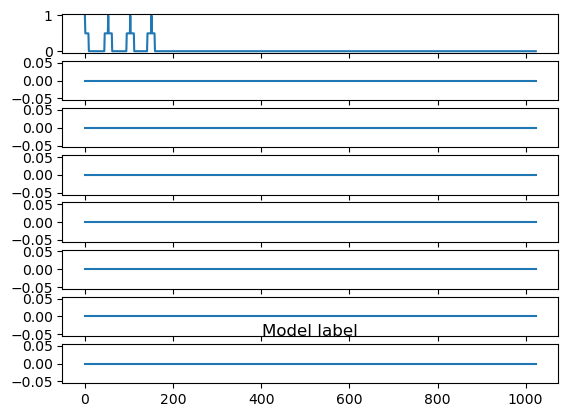

In [13]:
import matplotlib.pyplot as plt

num = 0
Y_data[num]
for i in range(len(code2drum)):
    plt.subplot(8,1,i+1)
    plt.plot(Y_data[num,:,i])
plt.title('Model label')
plt.show()

### 데이터셋 분리

In [14]:
# split train & test dataset
test_cnt = (int)(X_data.shape[0] * 0.2)

X_train, Y_train = X_data[:-test_cnt], Y_data[:-test_cnt]
X_test, Y_test = X_data[-test_cnt:], Y_data[-test_cnt:]

X_train.shape, Y_train.shape

((160, 1024, 1025), (160, 1024, 8))

# RNN 모델

## 악기 모두 한 번에 분류

In [ ]:
import tensorflow as tf

# build the model
model = tf.keras.Sequential()

# bidirection-RNN layer
unit_number = 50
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(unit_number, return_sequences=True, input_shape=(TIME_WIDTH, N_FFT // 2 + 1), activation='relu')))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(unit_number, return_sequences=True, activation='relu')))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(unit_number, return_sequences=True, activation='relu')))

# Flatten layer
model.add(tf.keras.layers.Flatten())

# dense layer
model.add(tf.keras.layers.Dense(TIME_WIDTH * len(code2drum), activation='sigmoid'))

model.build((None, TIME_WIDTH, N_FFT // 2 + 1))
model.summary()

In [ ]:
# compile the model
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# train the model
history = model.fit(X_train, Y_train, epochs=20)

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)

In [ ]:
import matplotlib.pyplot as plt

num = 0
X_predict = X_test[num].reshape((1, X_test[num].shape[0], X_test[num].shape[1]))
print(X_predict.shape)
prediction = model.predict(X_predict)

print(prediction)

predicted = prediction[0].reshape((TIME_WIDTH, len(code2drum)))

for i in range(len(code2drum)):
    plt.subplot(8,1,i+1)
    plt.plot(predicted[num,:,i])
plt.title('Model prediction result')
plt.show()

## crash

In [14]:
import tensorflow as tf

# build the model
model_cc = tf.keras.Sequential()

# bidirection-RNN layer
model_cc.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True, input_shape=(TIME_WIDTH, N_FFT // 2 + 1), activation='relu')))
model_cc.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='relu')))
model_cc.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='relu')))

# Flatten layer
model_cc.add(tf.keras.layers.Flatten())

# dense layer
model_cc.add(tf.keras.layers.Dense(TIME_WIDTH, activation='sigmoid'))

model_cc.build((None, TIME_WIDTH, N_FFT // 2 + 1))
model_cc.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1024, 100)         107600    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 1024, 100)         15100     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 1024, 100)         15100     
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 102400)            0         
                                                                 
 dense (Dense)               (None, 1024)              104858624 
                                                      

In [15]:
# compile the model_cc
opt_cc = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model_cc.compile(loss='binary_crossentropy', optimizer=opt_cc, metrics=['accuracy'])

In [16]:
# train the model_cc
history_cc = model_cc.fit(X_train, Y_train, epochs=20)

Epoch 1/20
3/3 [==============================] - 11s 2s/step - loss: 0.9886 - accuracy: 0.1235
Epoch 2/20
3/3 [==============================] - 6s 2s/step - loss: 0.1016 - accuracy: 0.8889
Epoch 3/20
3/3 [==============================] - 5s 2s/step - loss: 0.0744 - accuracy: 0.9630
Epoch 4/20
3/3 [==============================] - 5s 2s/step - loss: 0.0674 - accuracy: 0.9630
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 0.0601 - accuracy: 0.9630
Epoch 6/20
3/3 [==============================] - 6s 2s/step - loss: 0.0545 - accuracy: 0.9630
Epoch 7/20
3/3 [==============================] - 6s 2s/step - loss: 0.0493 - accuracy: 0.9630
Epoch 8/20
3/3 [==============================] - 6s 2s/step - loss: 0.0454 - accuracy: 0.9630
Epoch 9/20
3/3 [==============================] - 5s 2s/step - loss: 0.0433 - accuracy: 0.9630
Epoch 10/20
3/3 [==============================] - 6s 2s/step - loss: 0.0407 - accuracy: 0.9630
Epoch 11/20
3/3 [==============================]

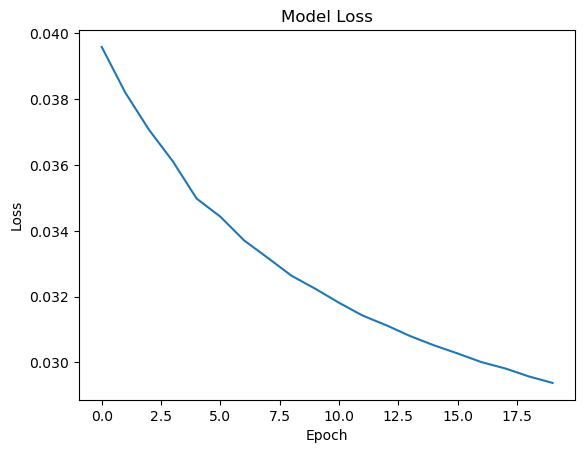

In [47]:
import matplotlib.pyplot as plt

# plot the loss results
plt.plot(history_cc.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

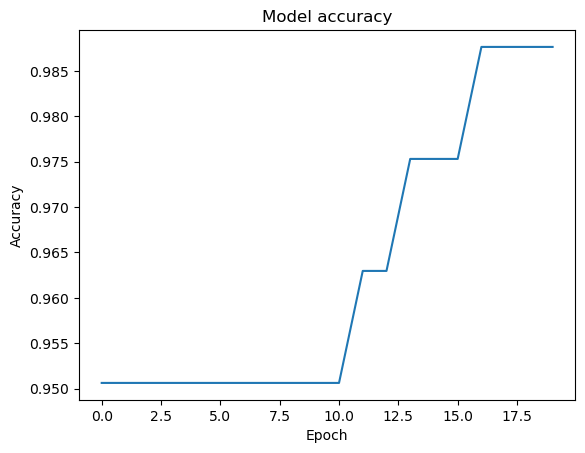

In [48]:
# plot the accuracy results
plt.plot(history_cc.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [17]:
loss, accuracy = model_cc.evaluate(X_test, Y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.0140 - accuracy: 0.9500


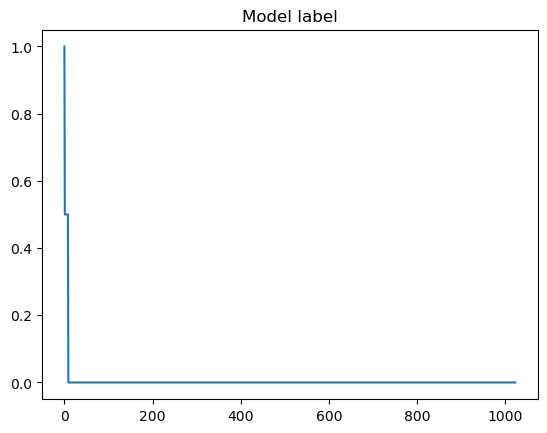

In [19]:
import matplotlib.pyplot as plt

num = 7
Y_test[num]
plt.plot(Y_test[num])
plt.title('Model label')
plt.show()

(1, 1024, 1025)
1/1 [==============================] - 0s 307ms/step
[[9.9932575e-01 4.3595362e-01 3.7084931e-01 ... 4.2046013e-04
  7.5537611e-07 8.9200701e-05]]


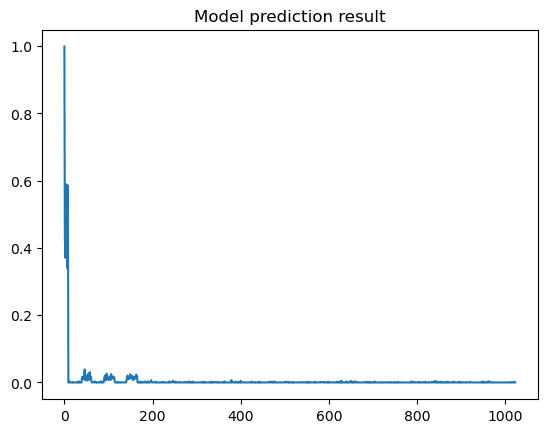

In [27]:
import matplotlib.pyplot as plt

num = 19
X_predict = X_test[num].reshape((1, X_test[num].shape[0], X_test[num].shape[1]))
print(X_predict.shape)
prediction = model_cc.predict(X_predict)

print(prediction)
plt.plot(prediction[0])
plt.title('Model prediction result')
plt.show()

## hi-hat

In [ ]:
import tensorflow as tf

# build the model
model_hh = tf.keras.Sequential()

# bidirection-RNN layer
model_hh.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True, input_shape=(TIME_WIDTH, N_FFT // 2 + 1), activation='relu')))
model_hh.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='relu')))
model_hh.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='relu')))

# Flatten layer
model_hh.add(tf.keras.layers.Flatten())

# dense layer
model_hh.add(tf.keras.layers.Dense(TIME_WIDTH, activation='sigmoid'))

model_hh.build((None, TIME_WIDTH, N_FFT // 2 + 1))
model_hh.summary()

# compile the model_hh
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model_hh.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# train the model_hh
history = model_hh.fit(X_train, Y_train, epochs=20)

In [ ]:
loss, accuracy = model_hh.evaluate(X_test, Y_test)

In [ ]:
num = 7
Y_test[num]
plt.plot(Y_test[num])
plt.title('Model label')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

X_predict = X_test[num].reshape((1, X_test[num].shape[0], X_test[num].shape[1]))
print(X_predict.shape)
prediction = model_hh.predict(X_predict)

print(prediction)
plt.plot(prediction[0])
plt.title('Model prediction result')
plt.show()